In [1]:
import sys, os, copy, re
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
def approx_ratio_stats(a, b):
    # Making a lot of assumptions about normality
    # and no covariance estimate ratio stats:
    # https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Supplemental_Modules_(Analytical_Chemistry)/Quantifying_Nature/Significant_Digits/Propagation_of_Error
    # I think this is derived from the first term of a Taylor expansion of the real solution.
    a_mean, a_stdev = a
    b_mean, b_stdev = b
    ratio_mean = a_mean / b_mean
    ratio_stdev = ratio_mean * np.sqrt((a_stdev / a_mean)**2 + (b_stdev / b_mean)**2)
    return((ratio_mean, ratio_stdev))

In [4]:
def RR2Asp(RR):
    return(54.863* (RR**1.0646))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [5]:
### Read measurements
annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('HT1080-2xGOT-KO_Asp-depl._timecourse.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['dilution']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

In [6]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values

In [9]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
#df['Pyr-Lac'] = (df['Pyruvate neg'] / df['Lactate neg']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)
#df['DHAP-G3P'] = (df['DHAP neg'] / df['Glycerol 3-phosphate neg']).replace(np.inf, np.nan)

In [10]:
df_mean = df.groupby(['Time', 'Rescue']).mean().reset_index()
df_stdev = df.groupby(['Time', 'Rescue']).std().reset_index()

In [12]:
# Normalize data to time 0 #
col_exclude = ['Time', 'Aspartate_media', 'Sample ID', 'ISTD Amt', 'Replicate', 'dilution', 'Rescue']

df_mean_norm = copy.deepcopy(df_mean)
df_stdev_norm = copy.deepcopy(df_stdev)

for idx in df_mean_norm.index.values:
    norm_mean = list()
    norm_stdev = list()
    mask0 = (df_mean['Time'] == 0) & (df_mean['Rescue'] == df_mean_norm.loc[idx, 'Rescue'])
    for colnam, val in zip(df_mean_norm.loc[idx,:].index.values, df_mean_norm.loc[idx,:].values):
        if colnam in col_exclude:
            norm_mean.append(df_mean_norm.loc[idx, colnam])
            norm_stdev.append(df_stdev_norm.loc[idx, colnam])
        else:
            a = (df_mean_norm.loc[idx, colnam], df_stdev_norm.loc[idx, colnam])
            b = (df_mean.loc[mask0, colnam].values[0], df_stdev.loc[mask0, colnam].values[0])
            ratio_mean, ratio_stdev = approx_ratio_stats(a, b)
            norm_mean.append(ratio_mean)
            norm_stdev.append(ratio_stdev)
    
    df_mean_norm.loc[idx,:] = norm_mean
    df_stdev_norm.loc[idx,:] = norm_stdev

<ipython-input-14-426e2f914651>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))


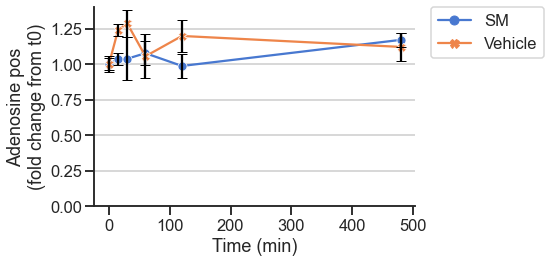

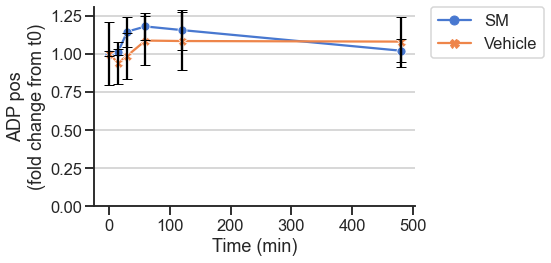

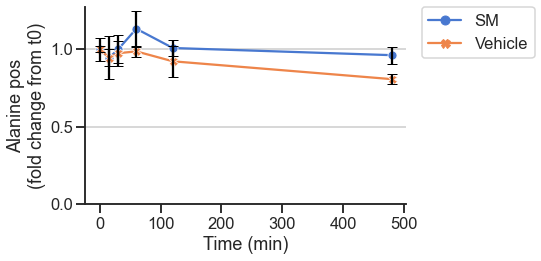

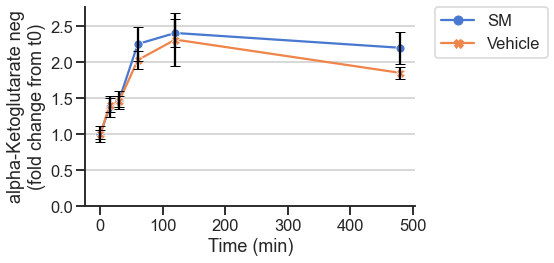

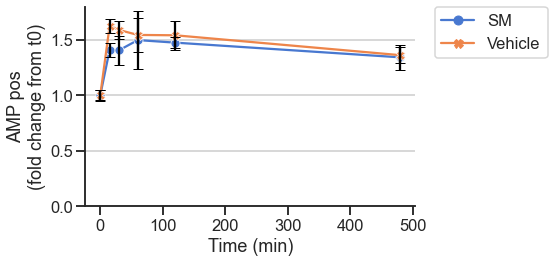

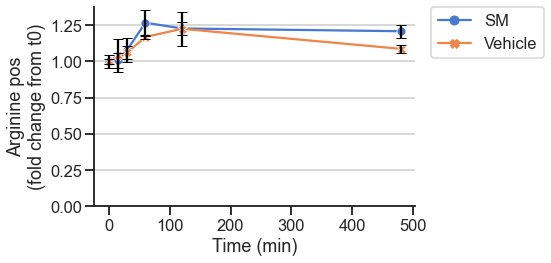

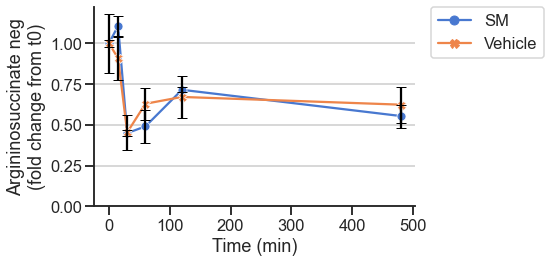

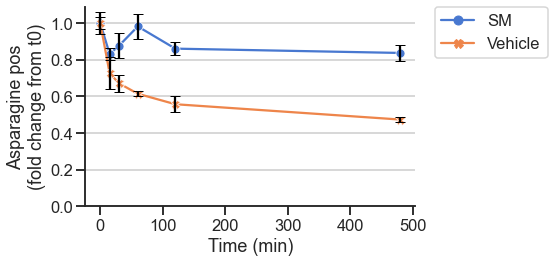

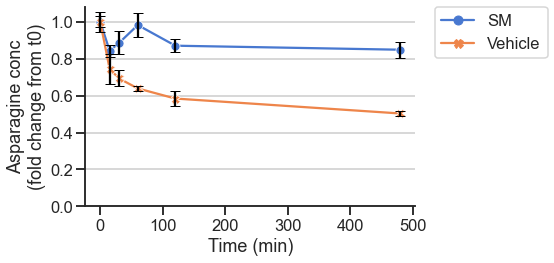

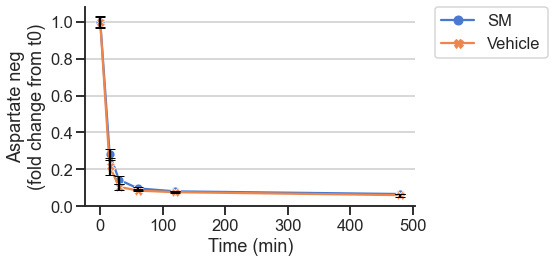

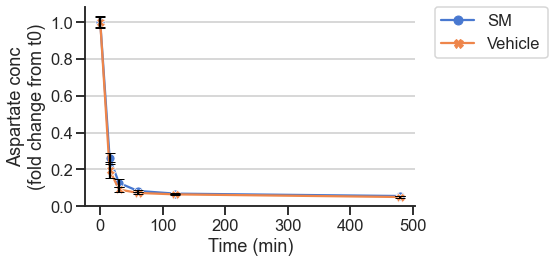

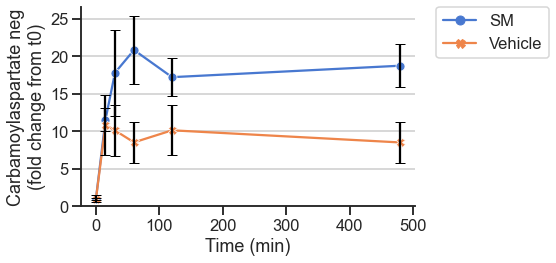

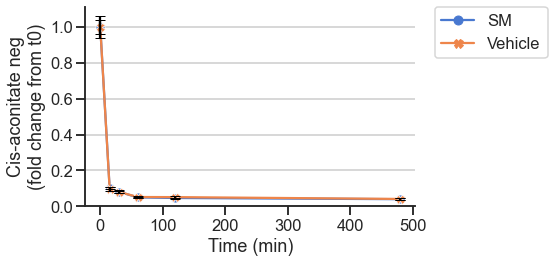

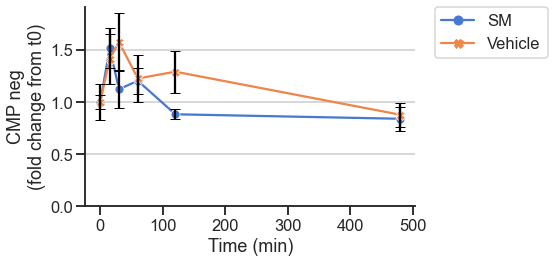

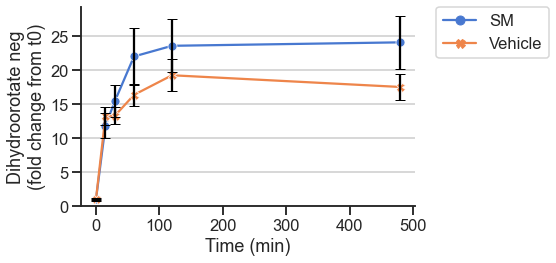

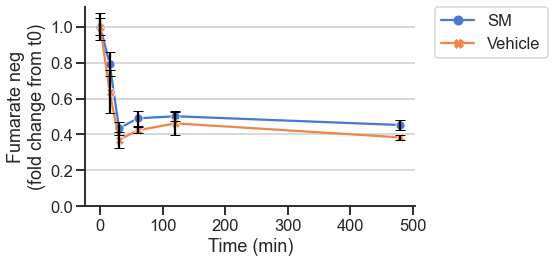

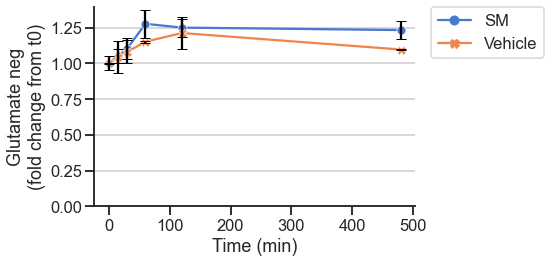

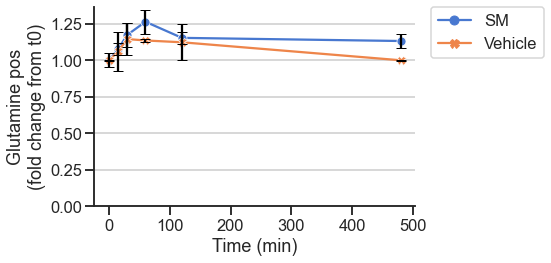

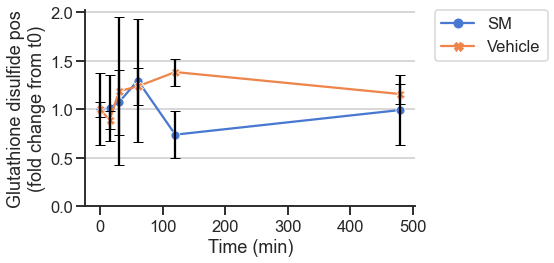

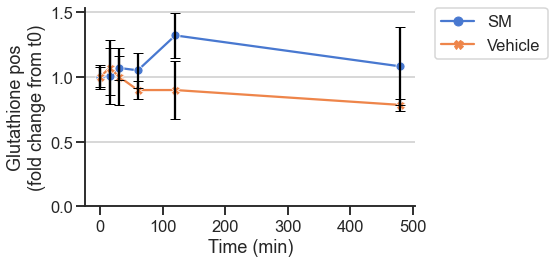

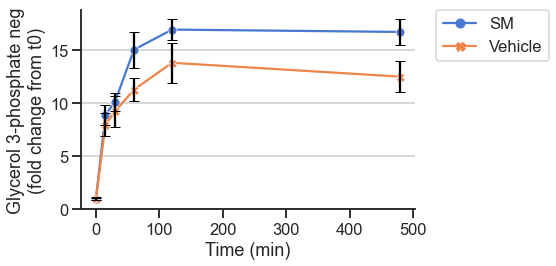

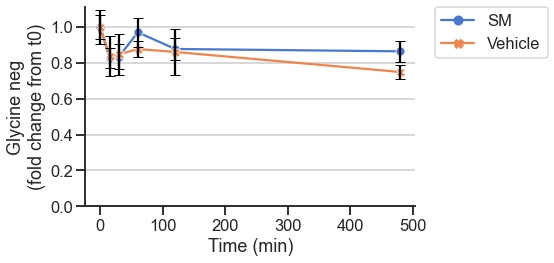

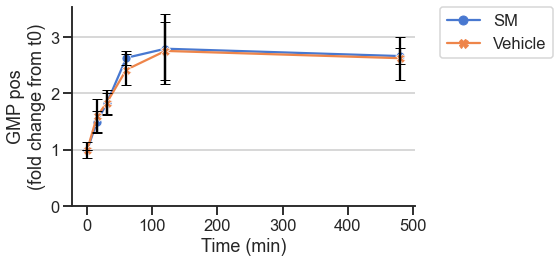

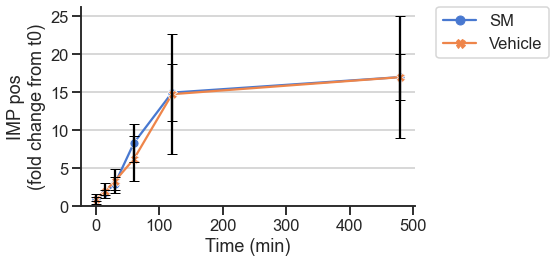

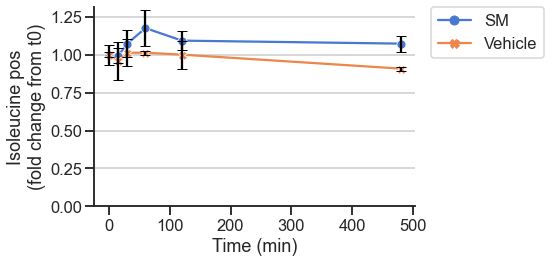

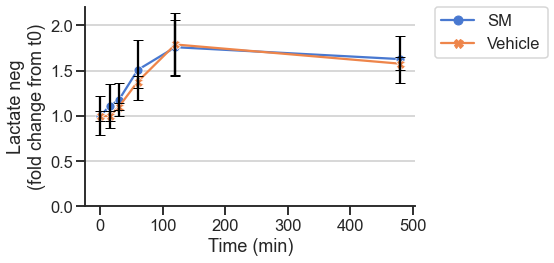

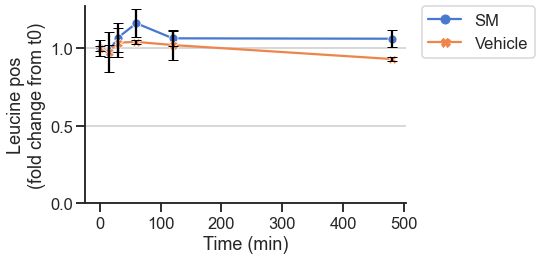

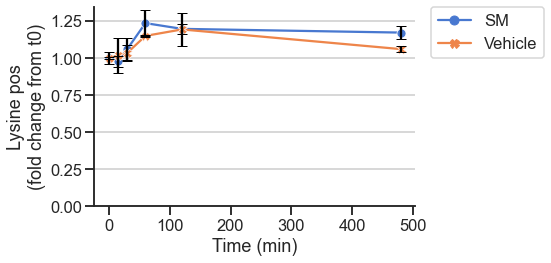

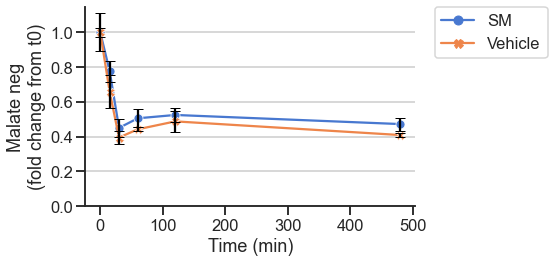

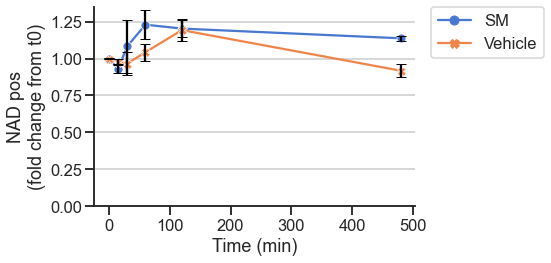

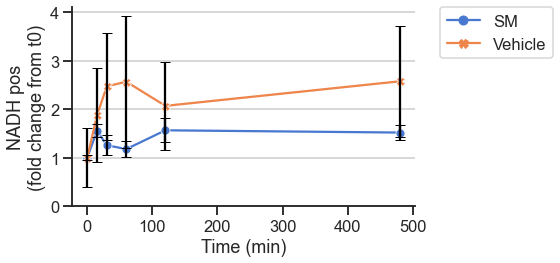

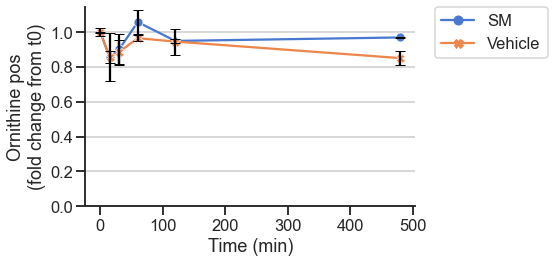

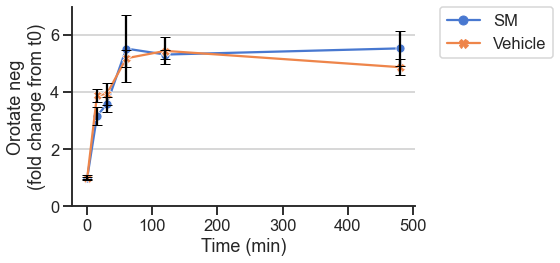

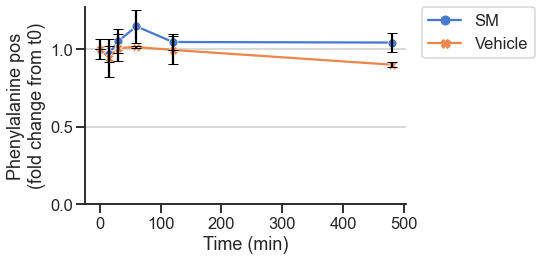

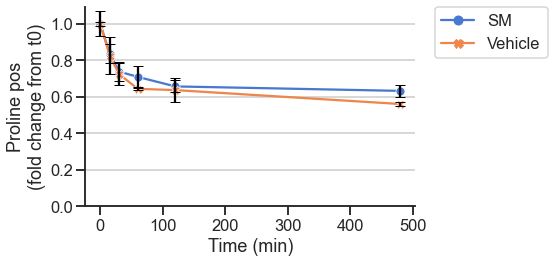

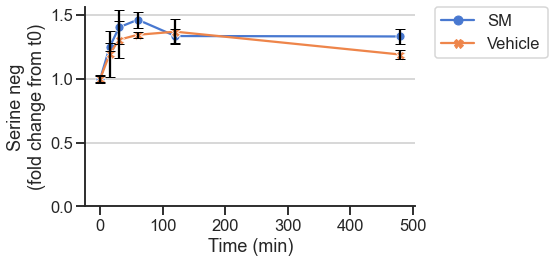

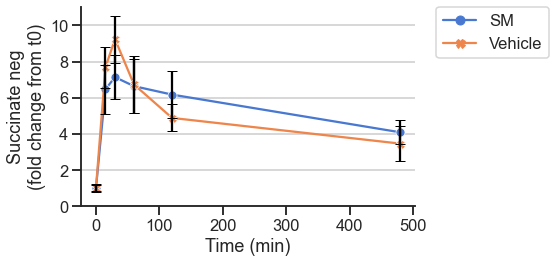

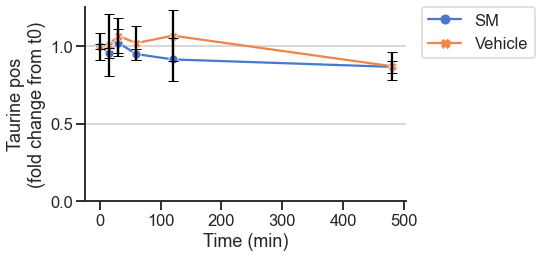

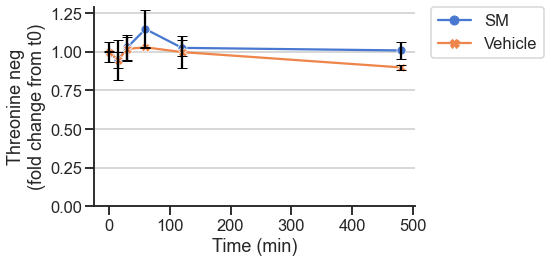

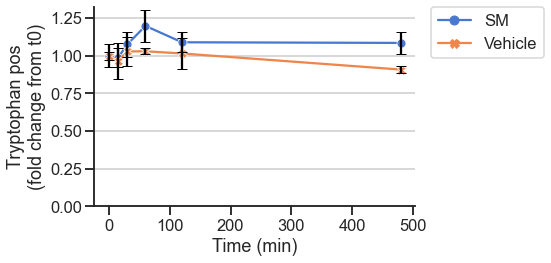

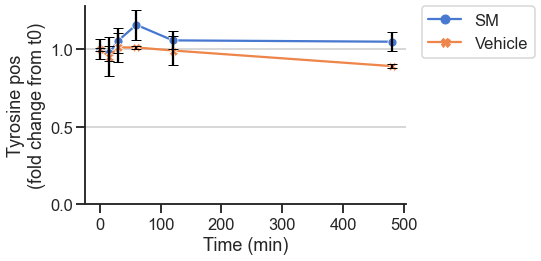

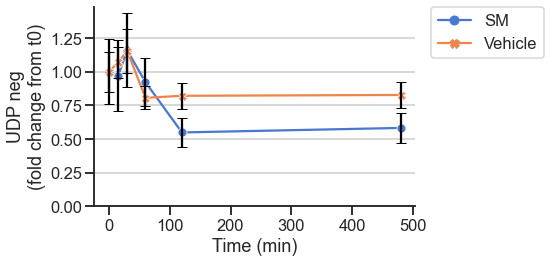

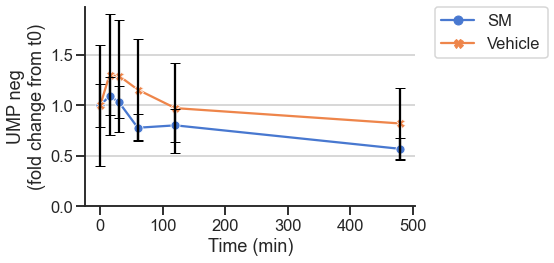

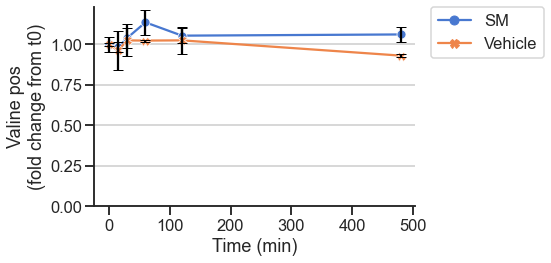

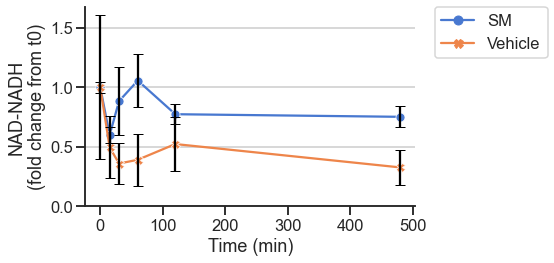

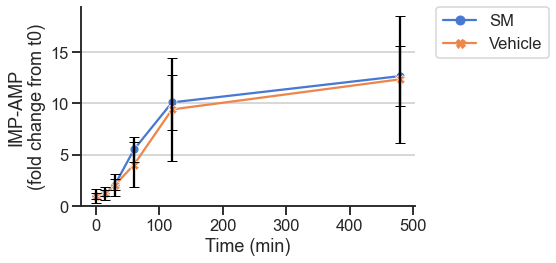

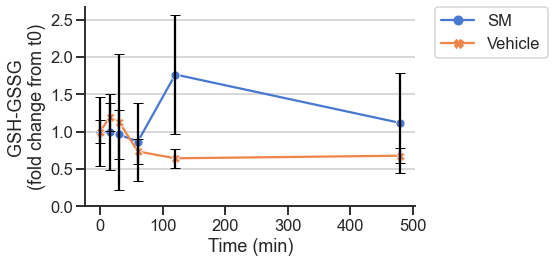

In [14]:
# Plot all ratios:
for colnam in df_mean_norm.columns.values:
    if colnam in col_exclude:
        continue

    #### Plot ####
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))

    g1 = sns.lineplot(ax=ax1, data=df_mean_norm, x='Time', y=colnam, hue='Rescue', style='Rescue', markers=True, dashes=False, zorder=10)
    g1.errorbar(y=df_mean_norm[colnam].values, x=df_mean_norm['Time'].values, yerr=df_stdev_norm[colnam].values, fmt='none', color='black', capsize=5, zorder=20)
    #g1.legend_.remove()
    g1.legend(bbox_to_anchor=(1.4, 1), borderaxespad=0)
    g1.set_ylim(0, g1.get_ylim()[1])
    g1.set_xlabel('Time (min)')
    g1.set_ylabel('{}\n(fold change from t0)'.format(colnam))

    g1.grid(True, axis='y')
    sns.despine()
    fig.tight_layout()
    if (df_mean_norm[colnam].values.max() / df_mean_norm[colnam].values.min()) > 2:
        fig.savefig('plots/ratio_change/over2Xdiff_{}.pdf'.format(colnam.replace(' ', '-')), bbox_inches='tight')
    else:
        fig.savefig('plots/ratio_change/{}.pdf'.format(colnam.replace(' ', '-')), bbox_inches='tight')


<ipython-input-17-2a92cb7e6867>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))


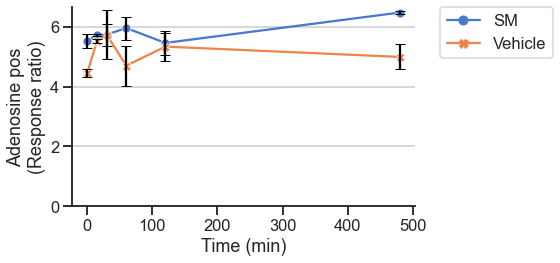

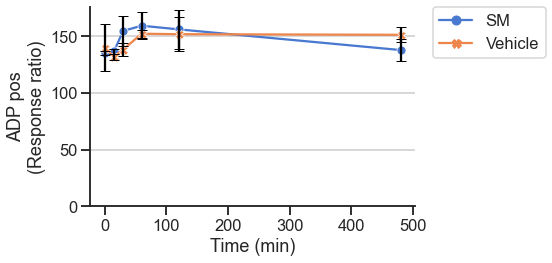

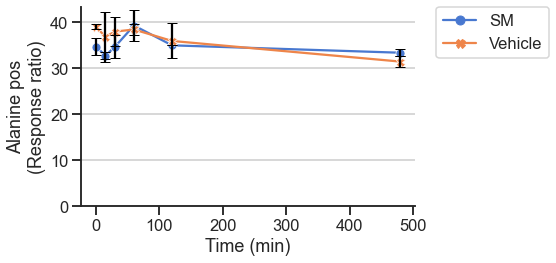

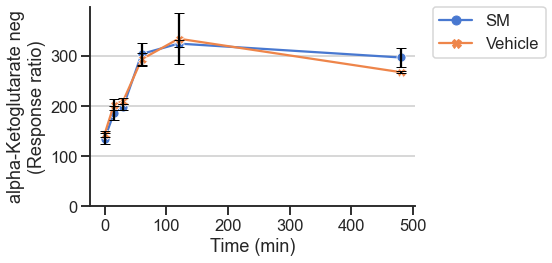

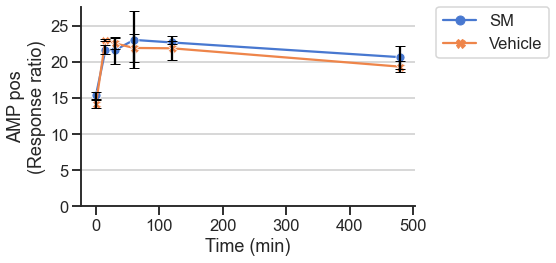

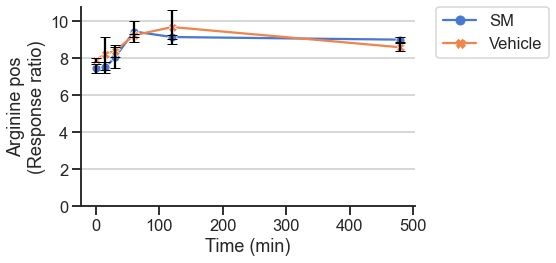

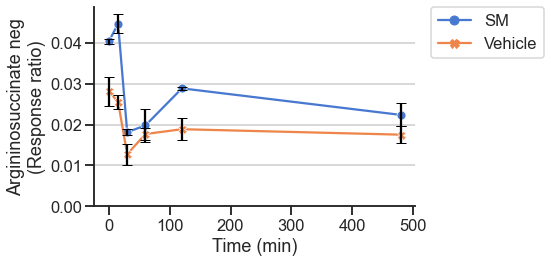

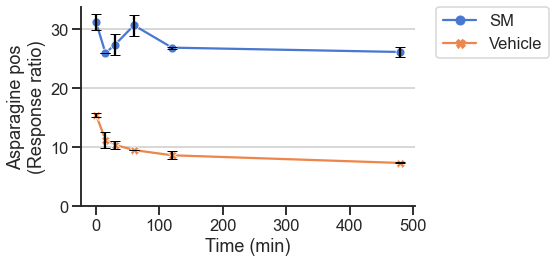

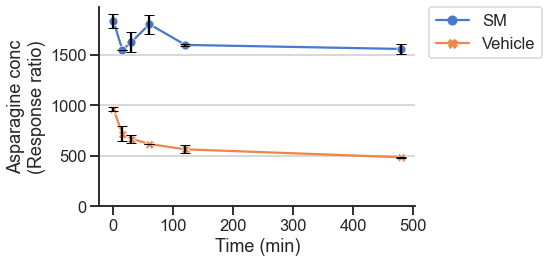

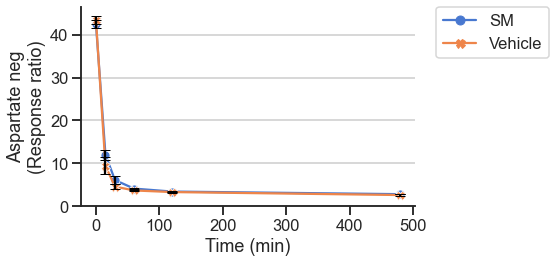

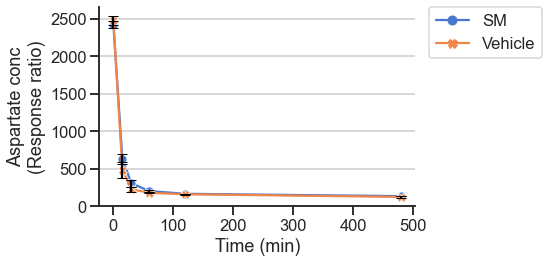

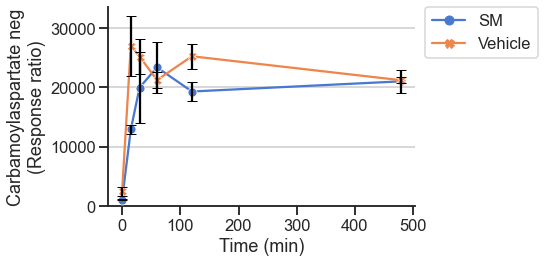

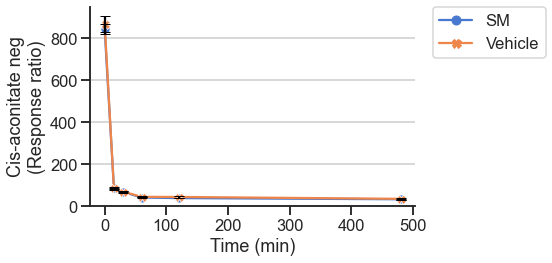

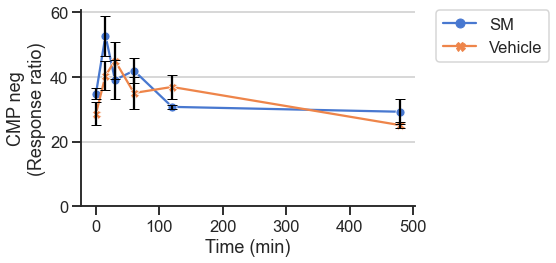

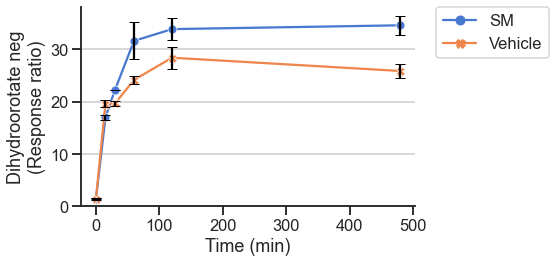

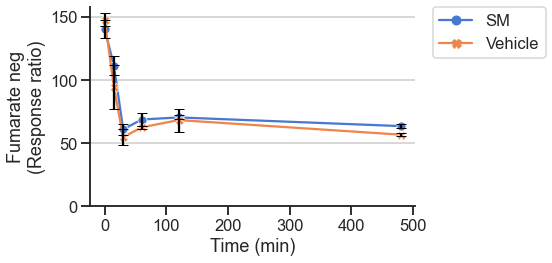

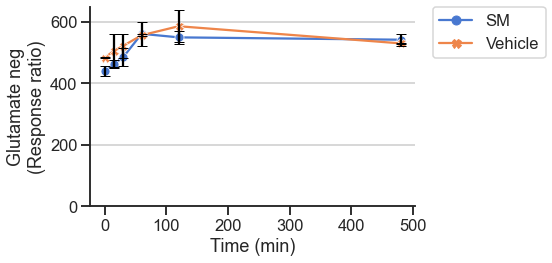

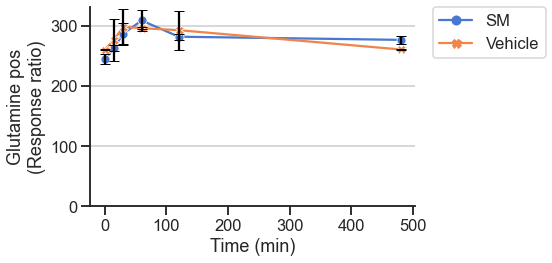

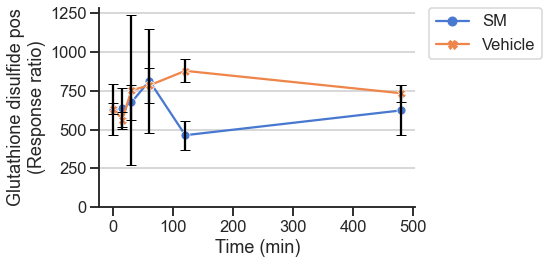

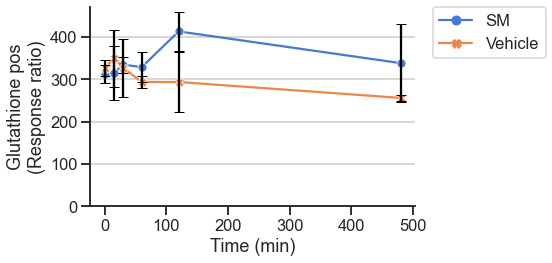

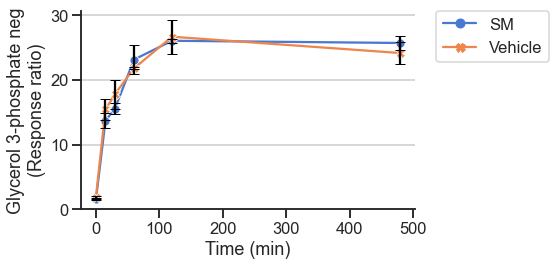

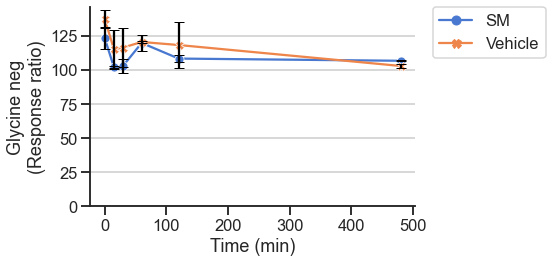

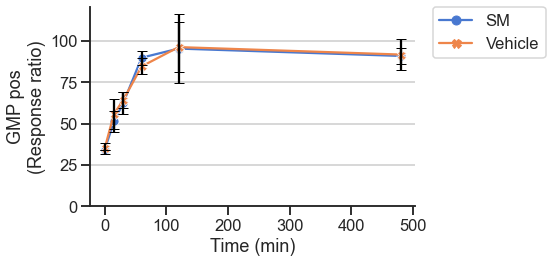

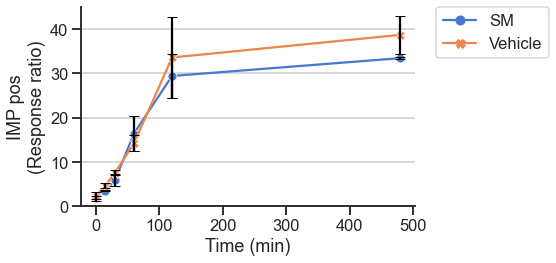

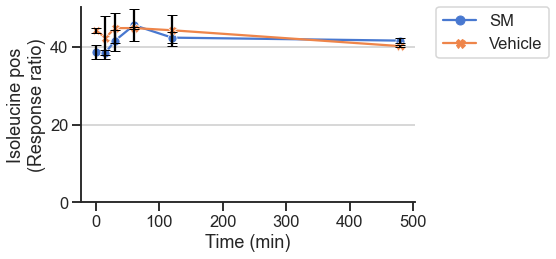

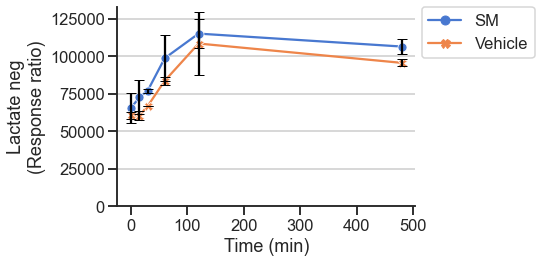

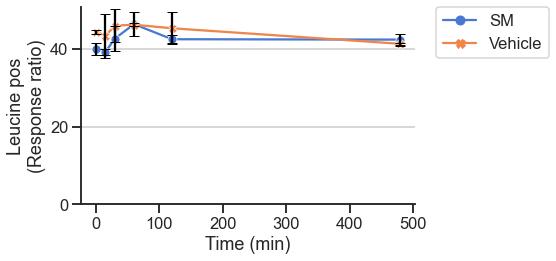

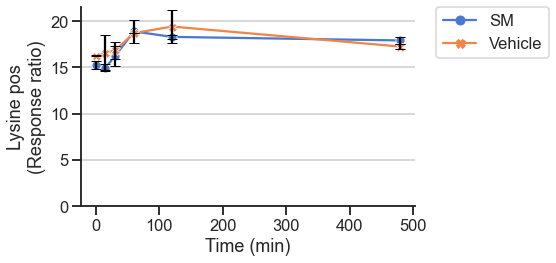

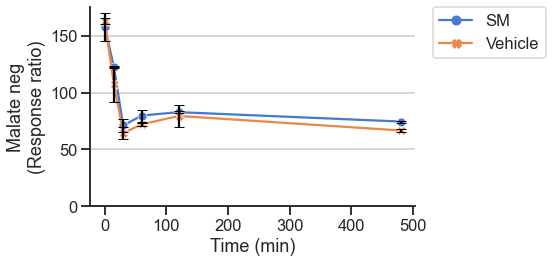

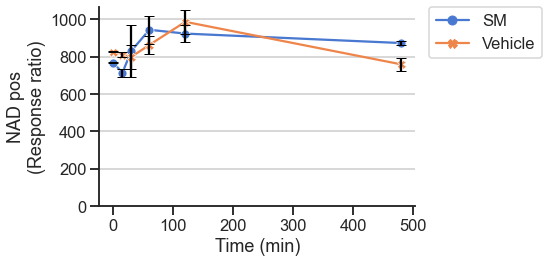

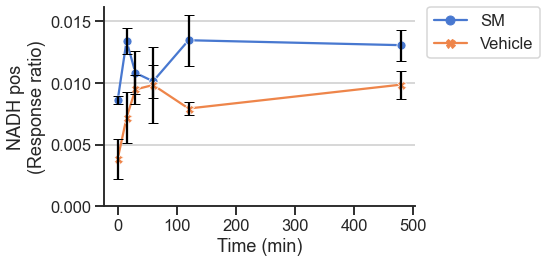

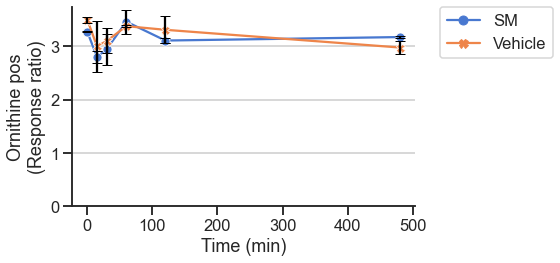

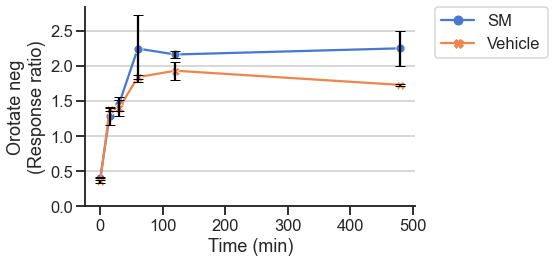

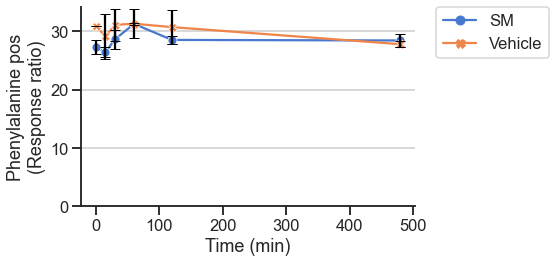

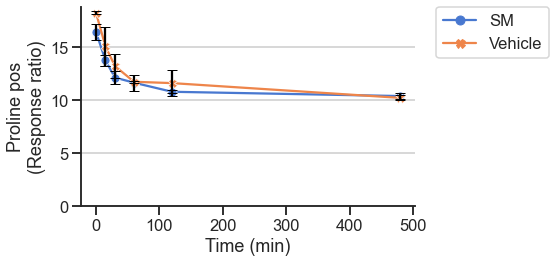

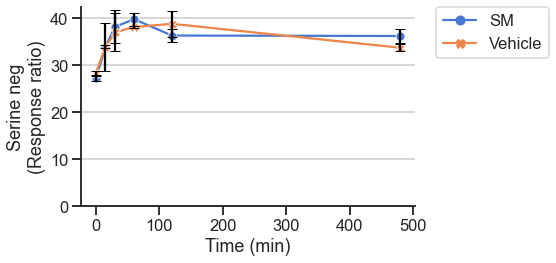

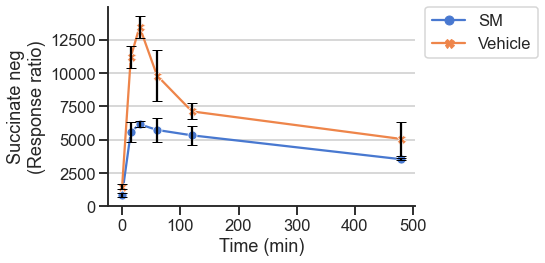

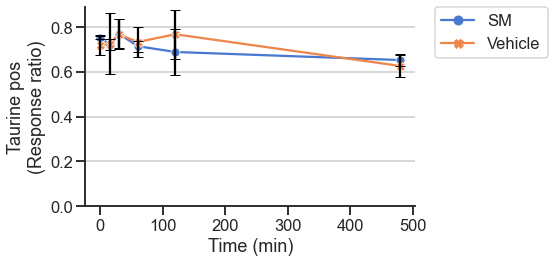

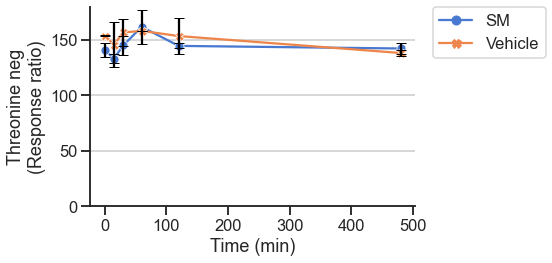

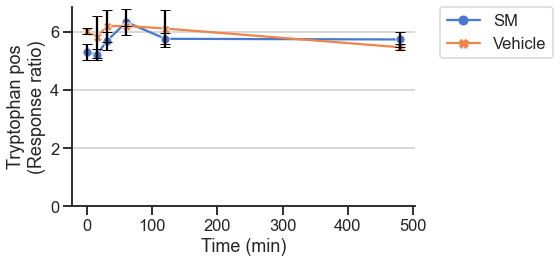

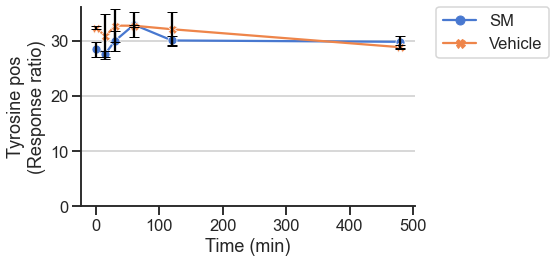

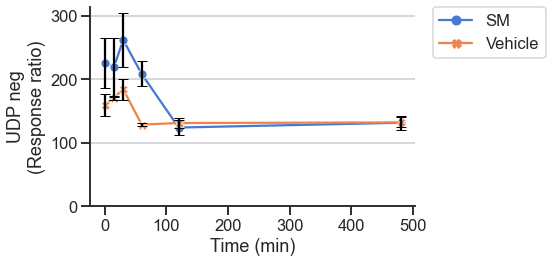

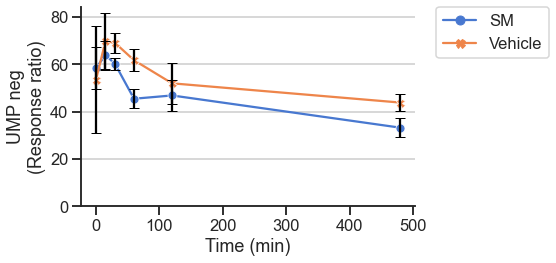

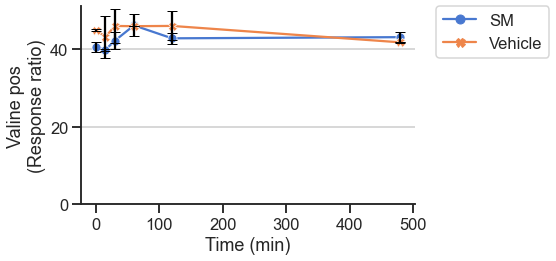

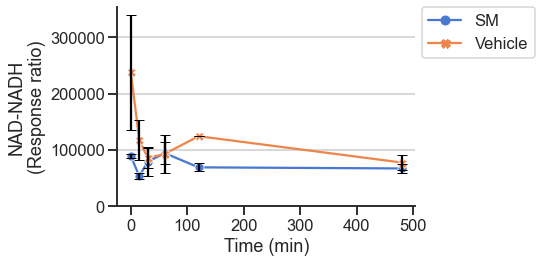

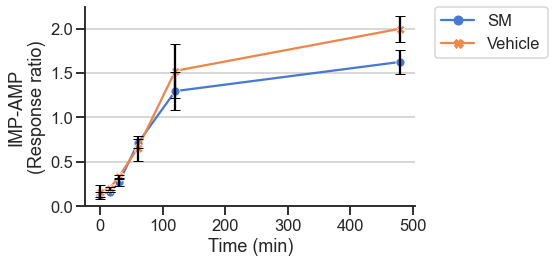

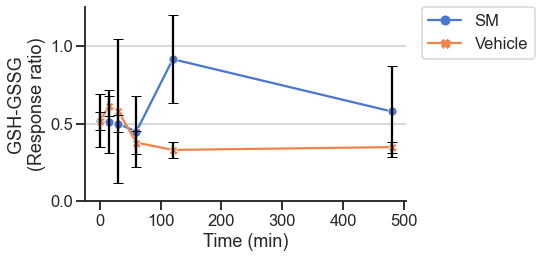

In [17]:
# Plot all ratios:
for colnam in df_mean.columns.values:
    if colnam in col_exclude:
        continue

    #### Plot ####
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))

    g1 = sns.lineplot(ax=ax1, data=df_mean, x='Time', y=colnam, hue='Rescue', style='Rescue', markers=True, dashes=False, zorder=10)
    g1.errorbar(y=df_mean[colnam].values, x=df_mean['Time'].values, yerr=df_stdev[colnam].values, fmt='none', color='black', capsize=5, zorder=20)
    #g1.legend_.remove()
    g1.legend(bbox_to_anchor=(1.4, 1), borderaxespad=0)
    g1.set_ylim(0, g1.get_ylim()[1])
    g1.set_xlabel('Time (min)')
    g1.set_ylabel('{}\n(Response ratio)'.format(colnam))

    g1.grid(True, axis='y')
    sns.despine()
    fig.tight_layout()
    if (df_mean_norm[colnam].values.max() / df_mean_norm[colnam].values.min()) > 2:
        fig.savefig('plots/response_change/over2Xdiff_{}.pdf'.format(colnam.replace(' ', '-')), bbox_inches='tight')
    else:
        fig.savefig('plots/response_change/{}.pdf'.format(colnam.replace(' ', '-')), bbox_inches='tight')


### Following is code reference for plotting, not with data from this experiment

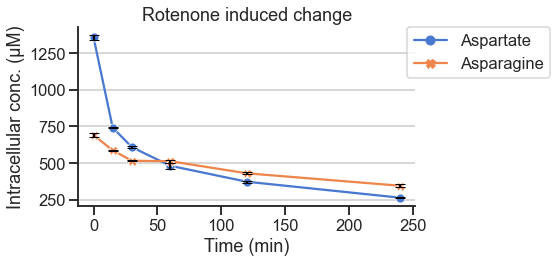

In [103]:
# Plot Asp/Asn concentrations #

df_mean_sele = df_mean.loc[:, ['Time', 'Aspartate conc', 'Asparagine conc']]
df_mean_sele = pd.melt(df_mean_sele, id_vars=['Time'], value_vars=['Aspartate conc', 'Asparagine conc'])
df_mean_sele['variable'] = [v[:-5] for v in df_mean_sele['variable'].values]

df_stdev_sele = df_stdev.loc[:, ['Time', 'Aspartate conc', 'Asparagine conc']]
df_stdev_sele = pd.melt(df_stdev_sele, id_vars=['Time'], value_vars=['Aspartate conc', 'Asparagine conc'])


fig, ax1 = plt.subplots(1, 1, figsize=(9, 4))
colnam = 'Aspartate conc'

g1 = sns.lineplot(ax=ax1, data=df_mean_sele, x='Time', y='value', hue='variable', style='variable', markers=True, dashes=False, zorder=10)
g1.errorbar(y=df_mean_sele['value'].values, x=df_mean_sele['Time'].values, yerr=df_stdev_sele['value'].values, fmt='none', color='black', capsize=5, zorder=20)
g1.set_xlabel('Time (min)')
g1.set_ylabel('Intracellular conc. (μM)')
g1.legend(bbox_to_anchor=(1.4, 1), borderaxespad=0)
g1.set_title('Rotenone induced change')

g1.grid(True, axis='y')
sns.despine()
fig.tight_layout()
fig.savefig('plots/Asp-Asn_conc.pdf', bbox_inches='tight')